In [1]:
import wave
import pyroomacoustics as pra
import numpy as np
from pydub import AudioSegment
import scipy.signal as sp
import scipy as scipy
import os
import matplotlib.pyplot as plt

# 順列計算に使用
import itertools
import time

In [2]:
sample_wave_file = "../data/raw/samaple/2speaker_yk.wav"

with wave.open(sample_wave_file) as wav:
    # ファイルの情報を出力する
    print("サンプリング周波数[Hz]:", wav.getframerate())
    print("サンプルサイズ[Byte]:", wav.getsampwidth())
    print("サンプル数:", wav.getnframes())
    print("チャンネル数:", wav.getnchannels())

サンプリング周波数[Hz]: 16000
サンプルサイズ[Byte]: 2
サンプル数: 152512
チャンネル数: 8


## 音量の変更

In [3]:
sourceAudio = AudioSegment.from_wav(sample_wave_file)
volume_delta = 50
# 音量を上げる
processedAudio = sourceAudio + volume_delta

basename = os.path.basename(sample_wave_file)
basename = os.path.splitext(basename)[0]
new_filename = f"{basename}_{volume_delta}.wav"

new_directory_path = os.path.join(os.path.dirname(sample_wave_file).replace("raw", "processed"))
os.makedirs(new_directory_path, exist_ok=True)

dst_wave_file = os.path.join(new_directory_path, new_filename)
processedAudio.export(dst_wave_file, format="wav")

with wave.open(dst_wave_file) as wav:
    # ファイルの情報を出力する
    print("サンプリング周波数[Hz]:", wav.getframerate())
    print("サンプルサイズ[Byte]:", wav.getsampwidth())
    print("サンプル数:", wav.getnframes())
    print("チャンネル数:", wav.getnchannels())

サンプリング周波数[Hz]: 16000
サンプルサイズ[Byte]: 2
サンプル数: 152512
チャンネル数: 8


音量を上げた後もチャンネル数はそのまま保存できている

## スマホでの録音データ分析

In [4]:
# m4aファイルを読み込み、wavに変換する
def convert_m4a_to_wav(m4a_file_path):
    audio = AudioSegment.from_file(m4a_file_path, "m4a")
    wav_file_path = os.path.splitext(m4a_file_path)[0] + ".wav"
    audio.export(wav_file_path, format="wav")
    return wav_file_path

sample_m4a_file = "../data/raw/propeller/self_record/2023-07-07.m4a"

# m4aをwavに変換
sample_wave_file = convert_m4a_to_wav(sample_m4a_file)

# 変換したwavファイルの情報を出力する
with wave.open(sample_wave_file) as wav:
    print("サンプリング周波数[Hz]:", wav.getframerate())
    print("サンプルサイズ[Byte]:", wav.getsampwidth())
    print("サンプル数:", wav.getnframes())
    print("チャンネル数:", wav.getnchannels())

サンプリング周波数[Hz]: 32000
サンプルサイズ[Byte]: 2
サンプル数: 624640
チャンネル数: 1


* スマホでの録音は 1 チャンネルだった
* サンプリング周波数が TAMAGO の 2 倍だった

In [5]:
def normalize_and_pad_audio_files(wave_files):
    audio_data = []
    n_samples = 0
    n_sources = len(wave_files)

    for wave_file in wave_files:
        with wave.open(wave_file) as wav:
            data = wav.readframes(wav.getnframes())
            data = np.frombuffer(data, dtype=np.int16)
            n_samples = max(wav.getnframes(), n_samples)
            data = data / np.iinfo(np.int16).max
            audio_data.append(data)

    for s in range(n_sources):
        if len(audio_data[s]) < n_samples:
            pad_width = n_samples - len(audio_data[s])
            audio_data[s] = np.pad(audio_data[s], (0, pad_width), "constant")
        audio_data[s] /= np.std(audio_data[s])
    return audio_data

In [6]:
np.random.seed(0)
wave_files = ["../data/raw/samaple/arctic_a0001.wav", "../data/raw/samaple/arctic_a0002.wav"]
audio_data = normalize_and_pad_audio_files(wave_files)

# パラメータの設定
n_sim_sources = 2
sample_rate = 16000
N = 1024
Nk = int(N / 2 + 1)
freqs = np.arange(0, Nk, 1) * sample_rate / N
SNR = 90.0
azimuth_th = 30.0
room_dim = np.array([10.0, 10.0, 10.0])

マイクロホンアレイの作成

In [7]:
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1
mic_directions = np.array([[np.pi / 2.0, theta / 180.0 * np.pi] for theta in np.arange(180, 361, 180)])

distance = 0.01
mic_alignments = np.zeros((3, mic_directions.shape[0]), dtype=mic_directions.dtype)
mic_alignments[0, :] = np.cos(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
print(mic_alignments[0, :], mic_alignments[0, :].shape)
mic_alignments[1, :] = np.sin(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
print(mic_alignments[1, :])
# mic_alignments[2, :] = np.cos(mic_directions[:, 0])
mic_alignments[2, :] = np.array([5, 5])
# print(mic_alignments[2, :])
mic_alignments *= distance
print(mic_directions)
print(mic_alignments)

R = mic_alignments + mic_array_loc[:, None]
room = pra.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room.add_microphone_array(pra.MicrophoneArray(R, fs=room.fs))

[-1.  1.] (2,)
[ 1.2246468e-16 -2.4492936e-16]
[[1.57079633 3.14159265]
 [1.57079633 6.28318531]]
[[-1.0000000e-02  1.0000000e-02]
 [ 1.2246468e-18 -2.4492936e-18]
 [ 5.0000000e-02  5.0000000e-02]]


音源の設定

In [8]:
# 場所
doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])
# 音源とマイクロホンの距離
distance = 1.0

source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
# source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

極座標系で指定する必要がないので修正が必要

In [9]:
print(mic_alignments.T)
print(source_locations.T)

[[-1.0000000e-02  1.2246468e-18  5.0000000e-02]
 [ 1.0000000e-02 -2.4492936e-18  5.0000000e-02]]
[[4.17640523 5.04001572 5.0978738 ]
 [6.17640523 5.04001572 5.0978738 ]]


Current elevation angle:

 30
Current azimuth angle: -60


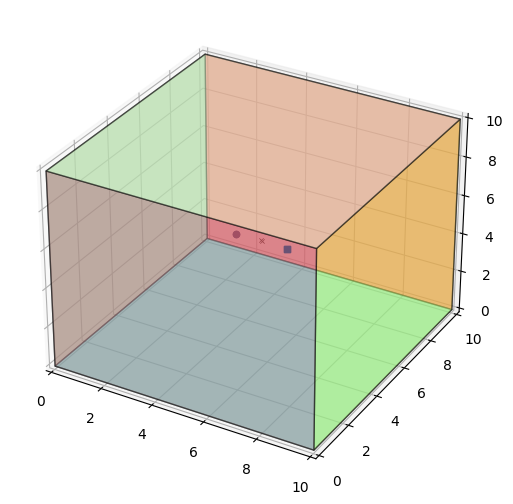

In [10]:
# シミュレーションを回す
for s in range(n_sim_sources):
    room.add_source(source_locations[:, s], signal=audio_data[s])

fig, ax = room.plot()
print("Current elevation angle:", ax.elev)  # 正面から上方向への角度
print("Current azimuth angle:", ax.azim)  # 真横から反時計回りの角度

In [11]:
def plot_room_views(room):
    # Create a new figure
    fig = plt.figure(figsize=(15, 6))

    # Create subplot for the top view
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    room.plot(fig=fig, ax=ax1)
    ax1.view_init(90, -90)
    ax1.set_title("Top View")

    # Create subplot for the front view
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    room.plot(fig=fig, ax=ax2)
    ax2.view_init(0, -90)
    ax2.set_title("Front View")

    # Create subplot for the side view
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    room.plot(fig=fig, ax=ax3)
    ax3.view_init(0, 0)
    ax3.set_title("Side View")

    # Show the plot
    plt.show()

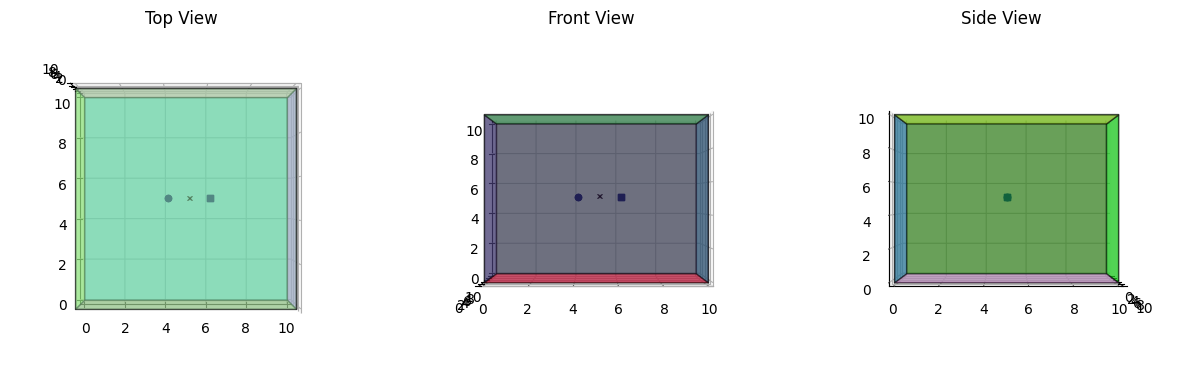

In [12]:
plot_room_views(room)

In [13]:
room.simulate(snr=SNR)
multi_conv_data = room.mic_array.signals

In [14]:
print(type(multi_conv_data))
print(multi_conv_data.shape)

<class 'numpy.ndarray'>
(2, 64450)


In [15]:
print(f"{len(audio_data)=}")
print(f"{audio_data[0].shape=}")
print(f"{audio_data[1].shape=}")

len(audio_data)=2
audio_data[0].shape=(64321,)
audio_data[1].shape=(64321,)


In [17]:
import sys
sys.path.append("../")
from src.file_io import write_signal_to_wav, write_signal_to_npz

In [18]:
write_signal_to_wav(multi_conv_data, "../data/processed/multi_conv_data.wav", sample_rate)
write_signal_to_npz(multi_conv_data, "../data/processed/multi_conv_data.npz", sample_rate)